In [1]:
import numpy as np
import pickle

from scipy.stats import spearmanr
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

# load explanations

In [2]:
#load explanations

#lime
method='lime'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']
n=3000

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_lime = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#kernelshap
method='kernelshap'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_kernelshap = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#vanillagrad
method='vanillagrad'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_vanillagrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#gradient*input
method='gradtinput'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_gradtinput = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}



#integrated gradients
method='integratedgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_integratedgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#smoothgrad
method='smoothgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_smoothgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


# calculate topk agreement + plot

In [3]:
#calculate topk agreement, two methods
def calc_topk_agreement_two_methods(attr1, attr2, k):
    '''
    attr1: np.array, n x p
    attr2: np.array, n x p
    '''
    #calculate feature ranks
    ranks1 = np.argsort(-np.abs(attr1), axis=1)
    ranks2 = np.argsort(-np.abs(attr2), axis=1)

    #get topk features
    topk1 = ranks1[:, 0:k]
    topk2 = ranks2[:, 0:k]

    #calculate proportion of features in common among top k
    topk1_sets = [set(row) for row in topk1]
    topk2_sets = [set(row) for row in topk2]
    prop_common_list = [len(setA.intersection(setB))/k for setA, setB in zip(topk1_sets, topk2_sets)] #prop for one datapoint = (#topk features in common)/k

    return np.array(prop_common_list) #proportion agreement among topk features for each datapoint


In [4]:
#calculate topk agreement, all methods
def calc_topk_agreement_all_methods(expl_methods_names, expl_methods_attrs, k):
    #initiate matrix
    num_expl_methods = len(expl_methods_attrs)
    topk_matrix = np.zeros([num_expl_methods, num_expl_methods])
    #fill matrix with pairwise topk agreement
    for a, b in itertools.combinations_with_replacement(range(num_expl_methods), 2):
        print(f'calculating {expl_methods_names[a]} ({a}) and {expl_methods_names[b]} ({b})')
        topk_agreement = calc_topk_agreement_two_methods(expl_methods_attrs[a], expl_methods_attrs[b], k) #prop. in common for each datapoint
        topk_matrix[a, b] = np.mean(topk_agreement) #average prop. in common
        topk_matrix[b, a] = topk_matrix[a, b]
    
    return topk_matrix


In [5]:
#plot
def plot_corr_matrix(corr_matrix, plot_path, 
                     labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    mask = np.invert(np.tril(np.ones_like(corr_matrix, dtype=bool))) #mask for upper triangle
    cmap = sns.color_palette('vlag', as_cmap=True) #diverging colormap
    
    #heatmap
    plt.figure(figsize=(15, 7))
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, 
                vmin=0, vmax=1, center=0,
                xticklabels=labels, yticklabels=labels,
                square=True, linewidths=.5, cbar_kws={'shrink': 0.995})
    plt.yticks(rotation=0)
    plt.savefig(plot_path, facecolor='white', transparent=False)

In [6]:
#full analysis function
def topk_agreement_analysis(expl_methods_names, expl_methods_attrs, k, plot_path, 
                              labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    topk_matrix = calc_topk_agreement_all_methods(expl_methods_names, expl_methods_attrs, k)
    plot_corr_matrix(topk_matrix, plot_path, labels)
    
    return topk_matrix

# results

### NN + logistic

----------- calculating top k agreement for nn, k=1
calculating LIME (0) and LIME (0)
calculating LIME (0) and KernelSHAP (1)
calculating LIME (0) and Grad (2)
calculating LIME (0) and Grad*Input (3)
calculating LIME (0) and IntGrad (4)
calculating LIME (0) and SmoothGRAD (5)
calculating KernelSHAP (1) and KernelSHAP (1)
calculating KernelSHAP (1) and Grad (2)
calculating KernelSHAP (1) and Grad*Input (3)
calculating KernelSHAP (1) and IntGrad (4)
calculating KernelSHAP (1) and SmoothGRAD (5)
calculating Grad (2) and Grad (2)
calculating Grad (2) and Grad*Input (3)
calculating Grad (2) and IntGrad (4)
calculating Grad (2) and SmoothGRAD (5)
calculating Grad*Input (3) and Grad*Input (3)
calculating Grad*Input (3) and IntGrad (4)
calculating Grad*Input (3) and SmoothGRAD (5)
calculating IntGrad (4) and IntGrad (4)
calculating IntGrad (4) and SmoothGRAD (5)
calculating SmoothGRAD (5) and SmoothGRAD (5)
[[1.         0.4851552  0.         0.97840756 0.97705803 0.        ]
 [0.4851552  1.   

[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
----------- calculating top k agreement for nn_logistic, k=1
calculating LIME (0) and LIME (0)
calculating LIME (0) and KernelSHAP (1)
calculating LIME (0) and Grad (2)
calculating LIME (0) and Grad*Input (3)
calculating LIME (0) and IntGrad (4)
calculating LIME (0) and SmoothGRAD (5)
calculating KernelSHAP (1) and KernelSHAP (1)
calculating KernelSHAP (1) and Grad (2)
calculating KernelSHAP (1) and Grad*Input (3)
calculating KernelSHAP (1) and IntGrad (4)
calculating KernelSHAP (1) and SmoothGRAD (5)
calculating Grad (2) and Grad (2)
calculating Grad (2) and Grad*Input (3)
calculating Grad (2) and IntGrad (4)
calculating Grad (2) and SmoothGRAD (5)
calculating Grad*Input (3) and Grad*Input (3)
calculating Grad*Input (3) and IntGrad (4)
calculating Grad*Input (3) and SmoothGRAD (5)
calculating IntGrad (4) and IntGrad (4)
calculating IntGrad (4) and SmoothGRAD (

[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]


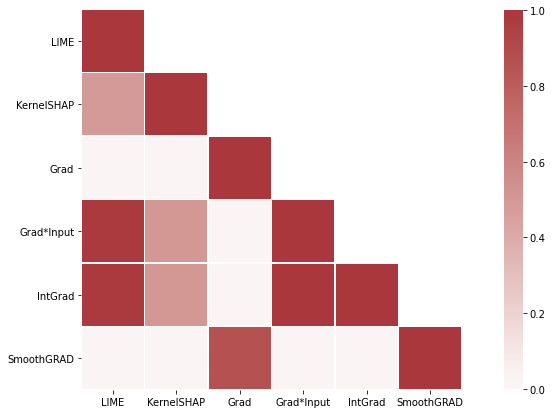

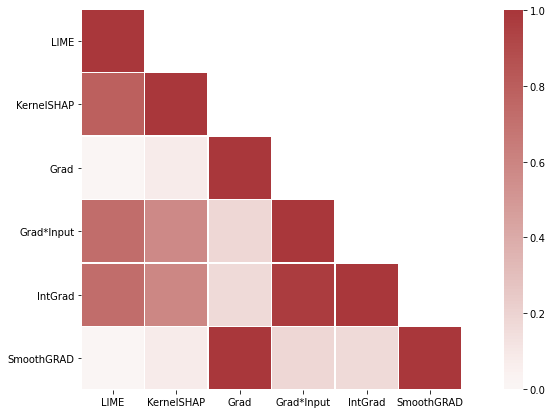

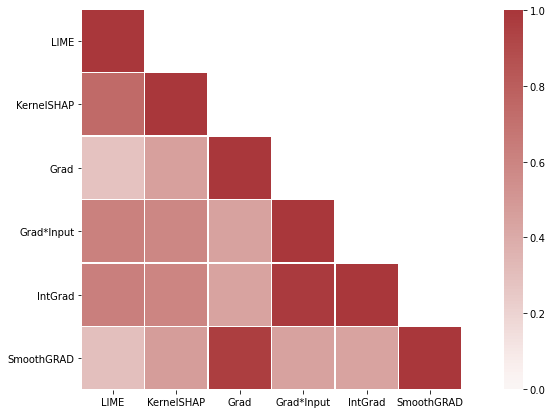

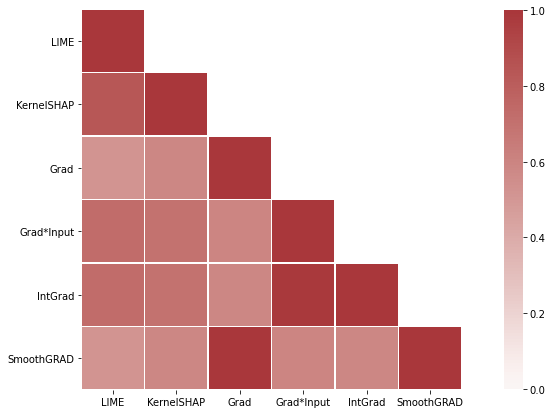

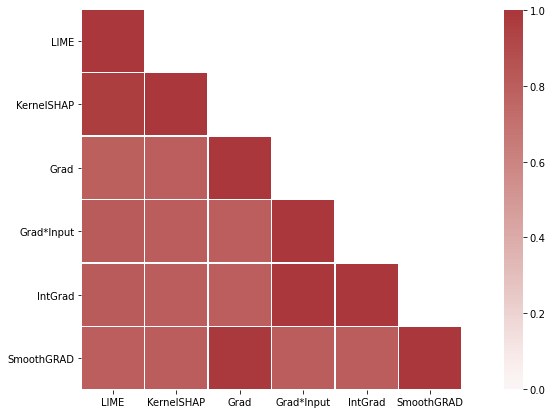

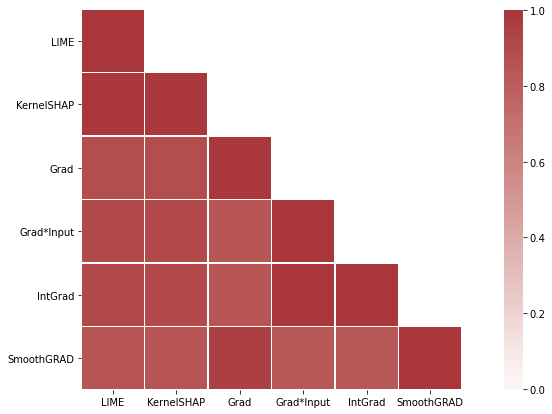

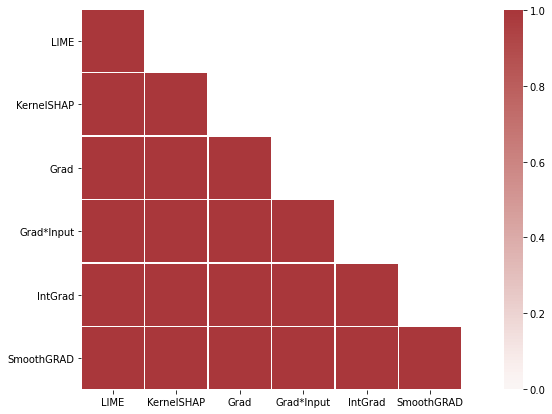

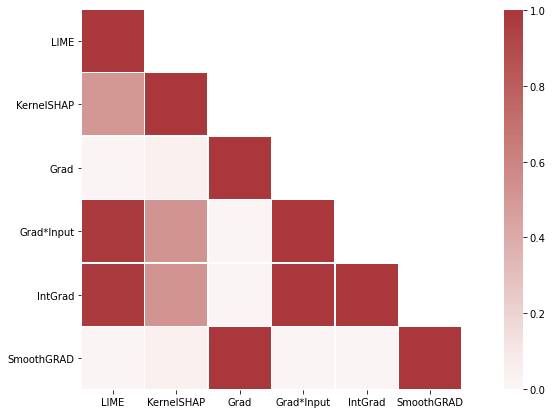

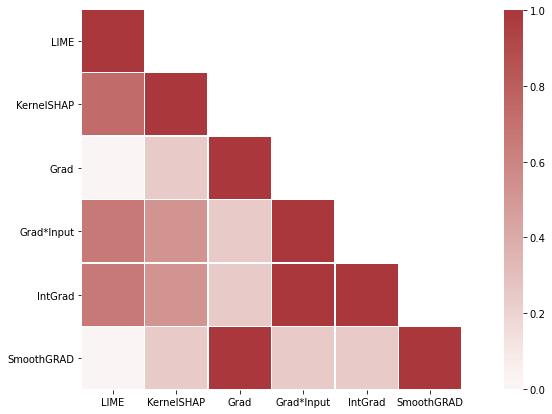

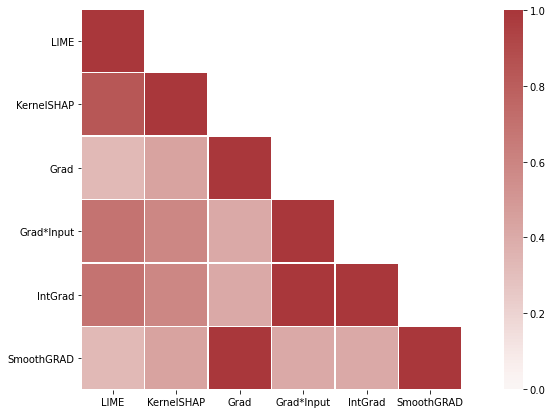

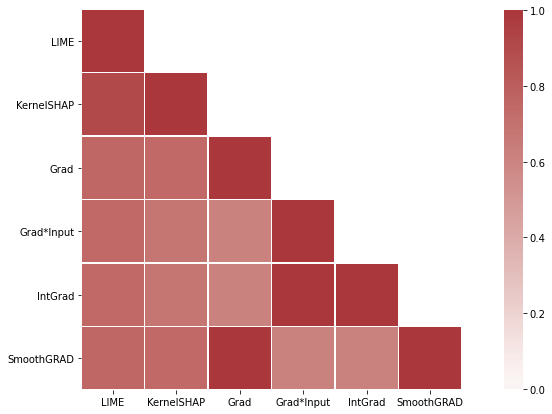

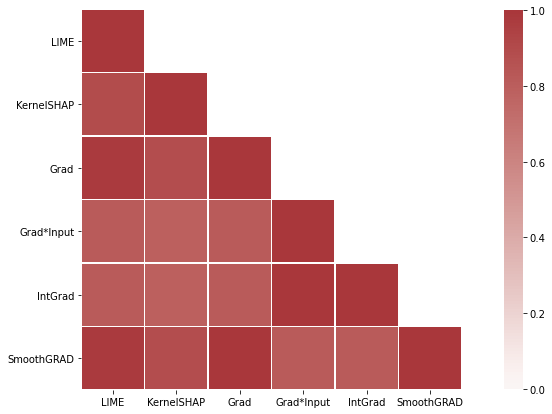

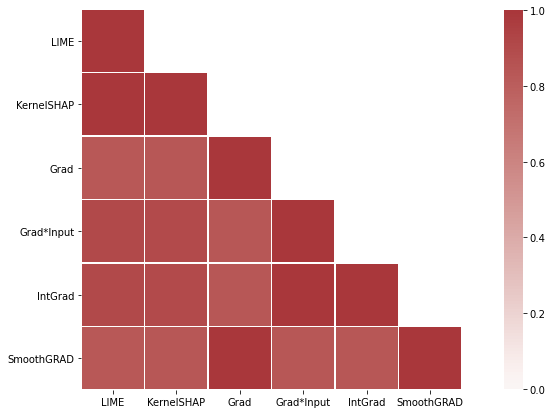

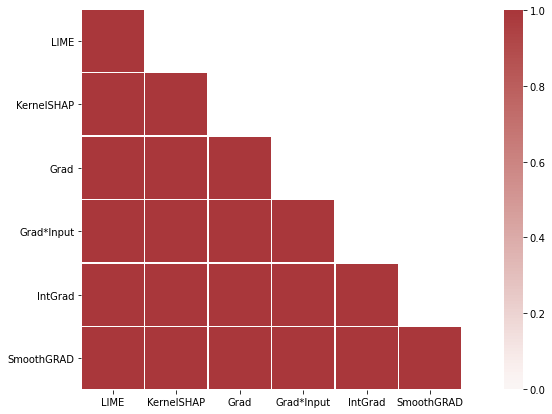

In [7]:
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}
max_k=7


for m in ['nn', 'nn_logistic']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m], 
                          2: attr_vanillagrad[m],
                          3: attr_gradtinput[m],
                          4: attr_integratedgrad[m],
                          5: attr_smoothgrad[m]}
    for k_i in range(1, max_k+1):
        print(f'----------- calculating top k agreement for {m}, k={k_i}')
        plot_path=f'figures/topk_agreement_{m}_k{k_i}.png'
        topk_matrix = topk_agreement_analysis(expl_methods_names, expl_methods_attrs, k=k_i, plot_path=plot_path)
        print(topk_matrix)

### RF + GB

----------- calculating top k agreement for rf, k=1
calculating LIME (0) and LIME (0)
calculating LIME (0) and KernelSHAP (1)
calculating KernelSHAP (1) and KernelSHAP (1)
[[1.         0.13292848]
 [0.13292848 1.        ]]
----------- calculating top k agreement for rf, k=2
calculating LIME (0) and LIME (0)
calculating LIME (0) and KernelSHAP (1)
calculating KernelSHAP (1) and KernelSHAP (1)
[[1.        0.3377193]
 [0.3377193 1.       ]]
----------- calculating top k agreement for rf, k=3
calculating LIME (0) and LIME (0)
calculating LIME (0) and KernelSHAP (1)
calculating KernelSHAP (1) and KernelSHAP (1)
[[1.         0.51394512]
 [0.51394512 1.        ]]
----------- calculating top k agreement for rf, k=4
calculating LIME (0) and LIME (0)
calculating LIME (0) and KernelSHAP (1)
calculating KernelSHAP (1) and KernelSHAP (1)
[[1.         0.64541161]
 [0.64541161 1.        ]]
----------- calculating top k agreement for rf, k=5
calculating LIME (0) and LIME (0)
calculating LIME (0) and K

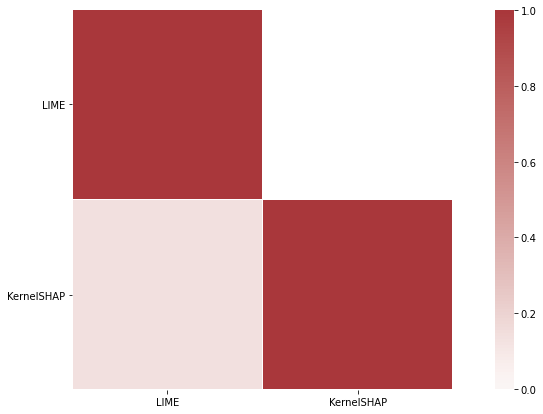

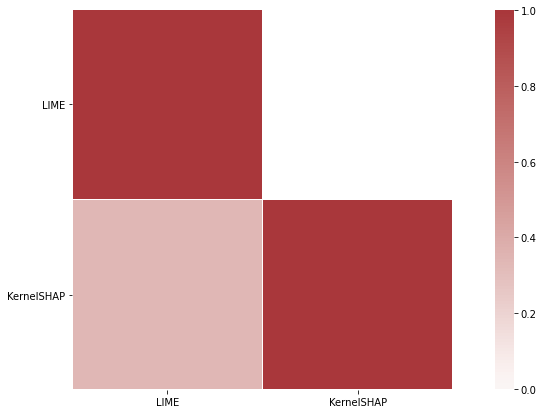

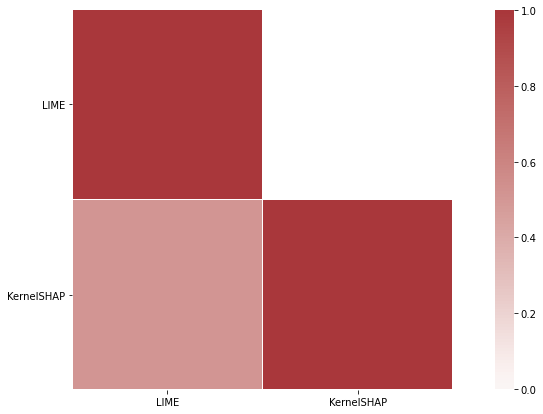

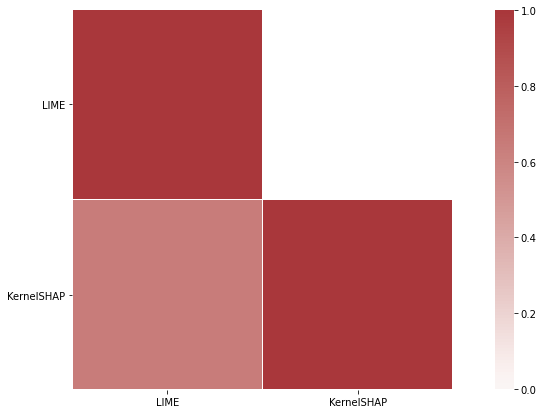

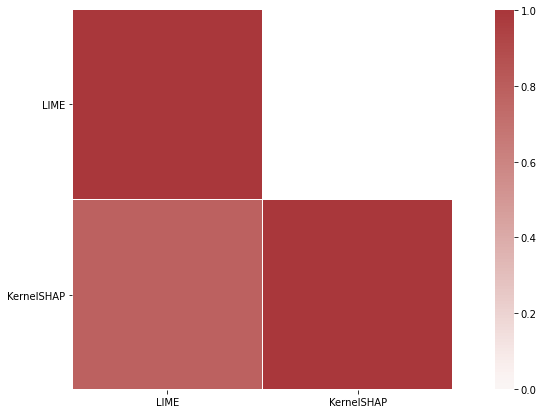

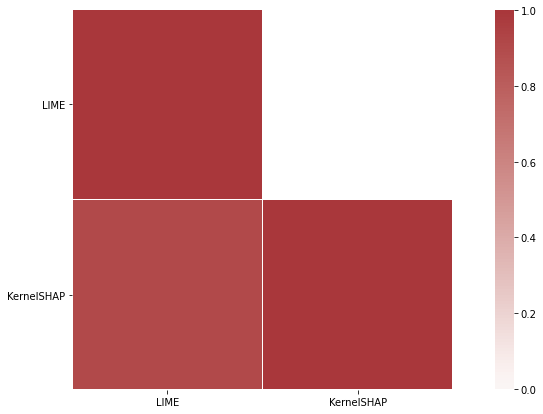

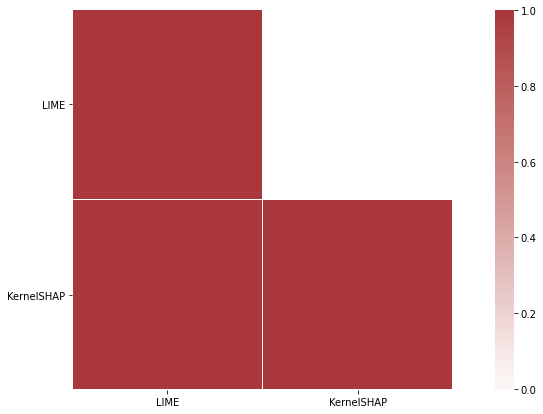

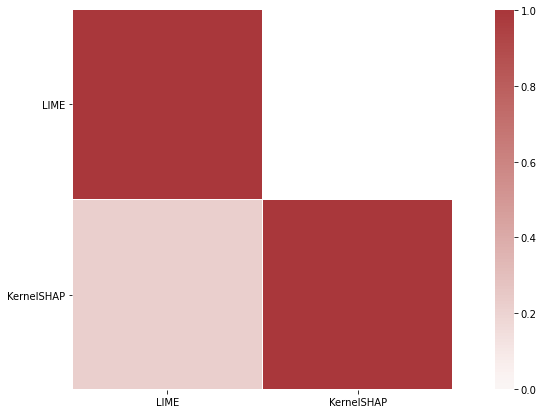

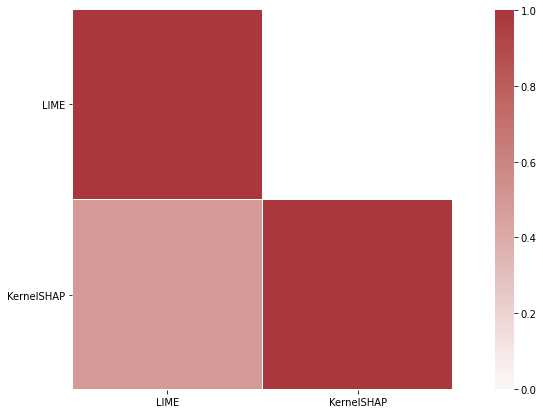

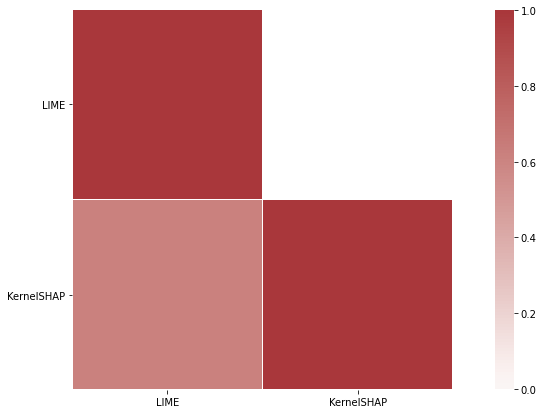

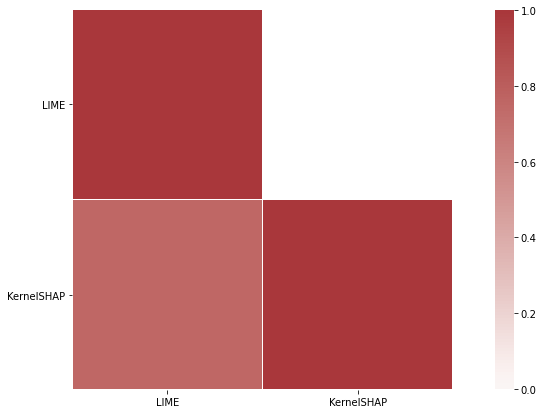

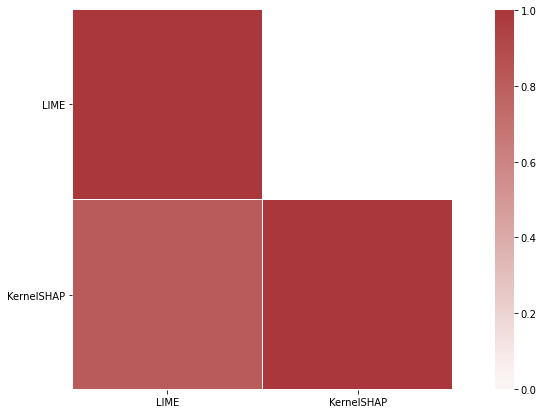

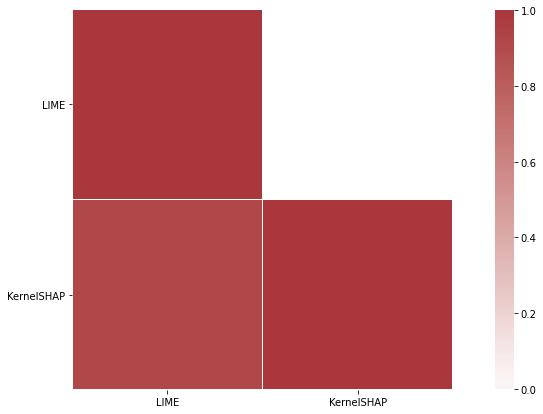

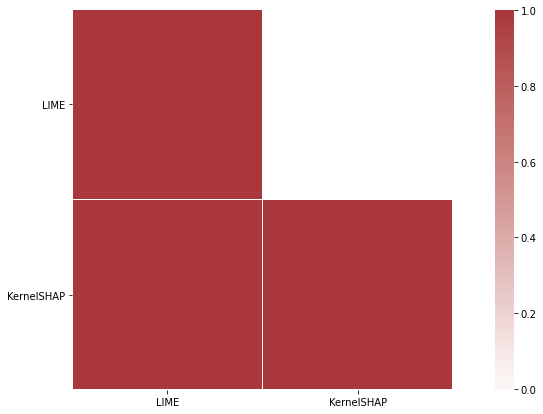

In [8]:
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP'}
max_k=7


for m in ['rf', 'gb']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m]}
    for k_i in range(1, max_k+1):
        print(f'----------- calculating top k agreement for {m}, k={k_i}')
        plot_path=f'figures/topk_agreement_{m}_{k_i}.png'
        topk_matrix = topk_agreement_analysis(expl_methods_names, expl_methods_attrs, k=k_i, 
                                              plot_path=plot_path, labels=['LIME', 'KernelSHAP'])
        print(topk_matrix)